In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8),
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma  
import pandas as pd
import sklearn
import tensorflow as tf

from amp.utils.basic_model_serializer import load_master_model_components
from amp.utils import basic_model_serializer
from amp.inference.filtering import amino_based_filtering         
import amp.data_utils.data_loader as data_loader
from amp.data_utils.sequence import pad, to_one_hot
from amp.utils import phys_chem_propterties as phys

from keras import backend, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import layers
from pathlib import Path
from keras import models as m
from tqdm import tqdm
from joblib import dump, load
from sklearn.decomposition import PCA
import os
import scipy

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

seed = 7

MIN_LENGTH = 0
MAX_LENGTH = 25
latent_dim = 64

input_to_encoder = layers.Input(shape=(MAX_LENGTH,))
input_to_decoder = layers.Input(shape=(latent_dim+2,))

Using TensorFlow backend.


In [3]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide.argmax(axis=1)])

def translate_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el-1] if el != 0 else "" for el in encoded_peptide])


In [4]:
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})

params = {'axes.labelsize': 8,'axes.titlesize':8, 'font.size': 8, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8}
plt.rcParams.update(params)

In [5]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

model_labels = [
    'HydrAMP',
    'PepCVAE',
    'Basic'
]


In [6]:
hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

In [7]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_molarweight(x:list):
    h = modlamp.descriptors.GlobalDescriptor(data)
    h.calculate_MW()
    return list(h.descriptor.flatten())

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())


def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)


def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())

def calculate_alphahelixpropensity(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'levitt_alpha')
    h.calculate_global()
    return list(h.descriptor.flatten())

def calculate_instability_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.instability_index()
    return list(h.descriptor.flatten())

def calculate_hscore(data:list):
    return [phys.helical_search(x) for x in data]


def calculate_hydrophobic_ratio(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.hydrophobic_ratio()
    return list(h.descriptor.flatten())
#     return [phys.helical_search(x) for x in data]

def calculate_boman_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.boman_index()
    return list(h.descriptor.flatten())


In [8]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

# Unconstrained

In [16]:
random.seed(seed)
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)


# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)


pos = np.vstack([amp_x_test[amp_y_test == 1], mic_x_test[mic_y_test < 1.5]])
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])
positives = [translate_peptide(x) for x in pos]
negatives = [translate_peptide(x) for x in neg]

#Load Uniprot
uniprot = list(pd.read_csv('../data/Uniprot_0_25_train.csv').Sequence)
uniprot = random.sample(uniprot, 50000)


#Get random peptides
random_gen = modlamp.sequences.Random(50000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [17]:
hydra_results = load(f'../results/unconstrained_{models[0]}.joblib')
pepcvae_results = load(f'../results/unconstrained_{models[1]}.joblib')
basic_results = load(f'../results/unconstrained_{models[2]}.joblib')

In [18]:
hydra_positives = select_peptides(hydra_results, 'pos').sequence.tolist()
hydra_negatives = select_peptides(hydra_results, 'neg').sequence.tolist()

pepcvae_positives = select_peptides(pepcvae_results, 'pos').sequence.tolist()
pepcvae_negatives = select_peptides(pepcvae_results, 'neg').sequence.tolist()

basic_positives = select_peptides(basic_results, 'pos').sequence.tolist()
basic_negatives = select_peptides(basic_results, 'neg').sequence.tolist()

In [19]:
len(hydra_positives)

50000

In [20]:
def calculate_physchem(peptides, datasets, n):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []
    physchem['alpha'] = []
    physchem['boman'] = []
    physchem['h_score'] = []
    physchem['hydrophobic_ratio'] = []
    physchem['instability'] = []

    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)
        physchem['alpha'] += calculate_alphahelixpropensity(dataset)
        physchem['boman'] += calculate_boman_index(dataset)
        physchem['hydrophobic_ratio'] += calculate_hydrophobic_ratio(dataset)
        physchem['h_score'] += calculate_hscore(dataset)        
        physchem['instability'] += calculate_instability_index(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [21]:
datasets = [
    'Random',
    'Uniprot',
    'Non-AMP test data',
    'Non-AMP HydrAMP',
    'Non-AMP PepCVAE',
    'Non-AMP Basic',
    'AMP test data',
    'AMP HydrAMP',
    'AMP PepCVAE',
    'AMP Basic',
        ]

peptides = [
    random_peptides,
    uniprot,
    negatives,
    hydra_negatives,
    pepcvae_negatives,
    basic_negatives,
    positives,    
    hydra_positives,
    pepcvae_positives,   
    basic_positives,    

]

In [22]:
physchem = calculate_physchem(peptides, datasets, 10000)

/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pszymczak/amp/new-tf/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
physchem

,dataset,length,charge,pi,aromacity,hydrophobicity,hm,alpha,boman,h_score,hydrophobic_ratio,instability
0,Random,5,-0.004,2.929688,0.000000,0.412000,0.374594,1.126000,-0.694000,0.500000,0.600000,31.440000
1,Random,14,-3.003,2.670898,0.285714,0.150000,0.128895,0.981429,1.472857,0.285714,0.285714,53.828571
2,Random,6,-0.003,3.732422,0.000000,-0.300000,0.796791,0.976667,4.115000,1.333333,0.333333,-4.233333
3,Random,22,2.927,9.546875,0.136364,-0.145000,0.190025,1.091818,2.321818,0.545455,0.363636,64.181818
4,Random,17,4.125,10.428711,0.117647,-0.247059,0.342113,0.997059,2.760588,0.902778,0.235294,0.311765
...,...,...,...,...,...,...,...,...,...,...,...,...
402567,AMP Basic,19,0.929,6.250000,0.105263,-0.056316,0.123410,0.944737,1.752632,0.477778,0.315789,18.278947
402568,AMP Basic,14,-2.804,3.887695,0.071429,-0.291429,0.174509,0.977857,3.942857,0.625000,0.142857,7.342857
402569,AMP Basic,22,7.824,10.696777,0.090909,-0.667273,0.141857,1.025455,4.732273,0.545455,0.318182,88.700000
402570,AMP Basic,16,4.995,12.156250,0.187500,-0.026875,0.116447,1.002500,1.270625,0.523810,0.312500,86.512500


In [24]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [25]:
datasets = [
    ['Random','Uniprot'],
    ['Non-AMP test data', 'AMP test data'],
    ['Non-AMP HydrAMP', 'AMP HydrAMP'],
    ['Non-AMP PepCVAE', 'AMP PepCVAE'],
    ['Non-AMP Basic', 'AMP Basic']
]

In [26]:
def wilcox(wilx_prop):
    if wilx_prop > 0.05:
        symbol = 'ns'
    if wilx_prop <= 0.05:
        symbol = '*'
    if wilx_prop <= 0.01:
        symbol = '**'
    if wilx_prop <= 0.001:
        symbol = '***'
    return symbol
    

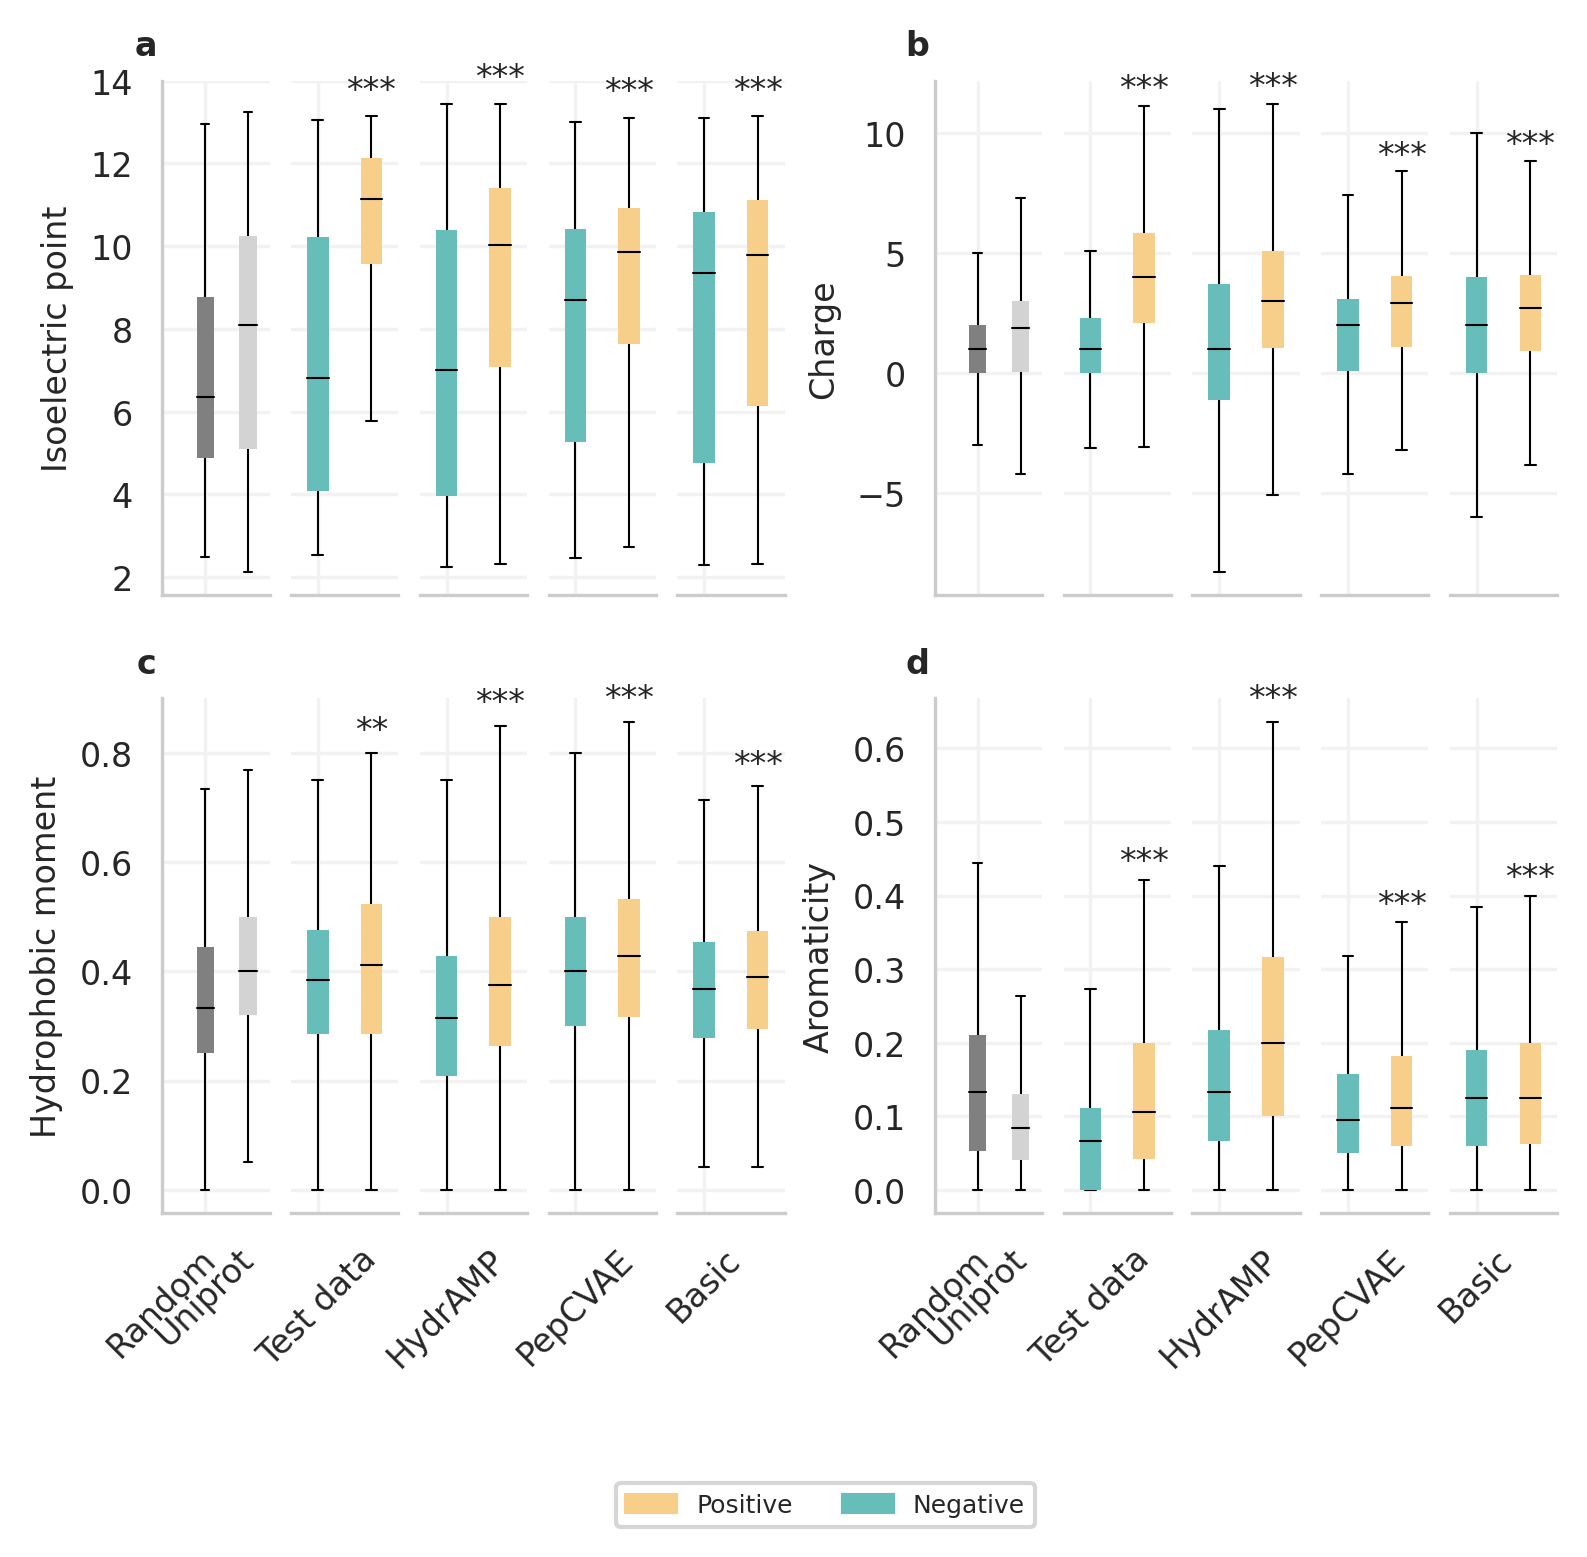

In [27]:
fig, master_axes = plt.subplots(
    ncols=11, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
#     gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0]}
)

palette = [
    'grey',
    'lightgray',
    'yellow',
    'violet',
    'yellow',
    'violet',   
    'yellow',
    'violet',    
    'yellow',
    'violet',    
]
for prop, label, axes, in zip(
    ['pi',  'charge',  'hydrophobic_ratio', 'aromacity', ],
    ['Isoelectric point', 'Charge',  'Hydrophobic moment', 'Aromaticity',],
    [master_axes[0][:5], master_axes[0][6:], master_axes[1][:5], master_axes[1][6:]] ,
):
    for ind, (ax, dataset) in enumerate(zip(axes, datasets)):
        data = [physchem[physchem['dataset'] == x][prop].tolist() for x in dataset]
        parts = ax.boxplot(
            data,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            flierprops=flierprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            widths=0.4      
        )
        if dataset == ['Random','Uniprot']:
            for patch, color in zip(parts['boxes'], ['grey','lightgray']):
                patch.set_facecolor(color)
        else:
            for patch, color in zip(parts['boxes'], ['#66BDBA', '#F7CF8B',]):
                patch.set_facecolor(color)
#             ax.set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])    
            ax.spines['left'].set_visible(False)
            ax.set_yticklabels([])
#         ax.set_xticks([])

        if dataset == ['Random', 'Uniprot']:
                continue
            
            
        if dataset == ['Non-AMP test data', 'AMP test data']:
            wilx_prop = mannwhitneyu(
                physchem[physchem.dataset == dataset[1]][prop].tolist(),
                physchem[physchem.dataset == dataset[0]][prop], 
                alternative='greater'
            )[1]    
        else:
            wilx_prop = wilcoxon(
                    physchem[physchem.dataset == dataset[1]][prop].tolist(),
                    physchem[physchem.dataset == dataset[0]][prop], 
                    alternative='greater'
            )[1]                    


#         print(prop, dataset, wilx_prop, symbol)
        symbol = wilcox(wilx_prop)

        ax.text(
            x=2,
            y=1.03 * parts['caps'][3].get_ydata()[1],
            s=symbol,
            ha='center'
        )   

    mins = [ax.get_ylim()[0] for ax in axes]
    maxs = [ax.get_ylim()[1] for ax in axes]
    for ax in axes:
        ax.set_ylim(min(mins), max(maxs))  
        
    axes[0].set_xticks(range(2))
    axes[0].set_xticklabels([], rotation=45)
    axes[1].set_xticks([1])   
    axes[1].set_xticklabels([], rotation=45)
    axes[2].set_xticks([1])   
    axes[2].set_xticklabels([], rotation=45)   
    axes[3].set_xticks([1])   
    axes[3].set_xticklabels([], rotation=45)       
    axes[4].set_xticks([1])   
    axes[4].set_xticklabels([], rotation=45)       
    
    axes[0].set_ylabel(label)
    
fig.delaxes(master_axes[0][5])
fig.delaxes(master_axes[1][5])

for i, (label, ax) in enumerate(
    zip(
        ['a', 'b', 'c', 'd'],
        [master_axes[0][0], master_axes[0][6], master_axes[1][0], master_axes[1][6]]
    )
):
    ax.annotate(label, xy=(-0.05, 1.1), xycoords='axes fraction',
      fontweight='bold', va='top', ha='right')

    master_axes[1][0].set_xticks(range(2))
    master_axes[1][0].set_xticklabels(['Random','Uniprot'], rotation=45)
    master_axes[1][1].set_xticks([1])   
    master_axes[1][1].set_xticklabels(['Test data'], rotation=45)
    master_axes[1][2].set_xticks([1])   
    master_axes[1][2].set_xticklabels(['HydrAMP'], rotation=45)   
    master_axes[1][3].set_xticks([1])   
    master_axes[1][3].set_xticklabels(['PepCVAE'], rotation=45)       
    master_axes[1][4].set_xticks([1])   
    master_axes[1][4].set_xticklabels(['Basic'], rotation=45)       
    
    master_axes[1][6].set_xticks(range(2))
    master_axes[1][6].set_xticklabels(['Random','Uniprot'], rotation=45)
    master_axes[1][7].set_xticks([1])   
    master_axes[1][7].set_xticklabels(['Test data'], rotation=45)
    master_axes[1][8].set_xticks([1])   
    master_axes[1][8].set_xticklabels(['HydrAMP'], rotation=45)   
    master_axes[1][9].set_xticks([1])   
    master_axes[1][9].set_xticklabels(['PepCVAE'], rotation=45)       
    master_axes[1][10].set_xticks([1])   
    master_axes[1][10].set_xticklabels(['Basic'], rotation=45)            
    
plt.legend(
    handles=[
#         mpatches.Patch(color=palette[0], label='Random'),
#         mpatches.Patch(color=palette[1], label='Uniprot'),  
        mpatches.Patch(color='#F7CF8B', label='Positive'),    
        mpatches.Patch(color='#66BDBA', label='Negative'),
    ], 
    bbox_to_anchor = (-3.75, -0.5),
    ncol=4,
)
    
# fig.tight_layout()
fig.savefig("../figures/Fig4-Wilcox.svg")
fig.savefig("../figures/Fig4-Wilcox.pdf", bbox_inches="tight")
plt.show()